In [1]:
import torch
import numpy as np
from ltn_imp.automation.knowledge_base import KnowledgeBase
from ltn_imp.automation.data_loaders import LoaderWrapper

## Data and Model Preparation

In [2]:
nr_samples = 100
dataset = torch.rand((nr_samples, 2))
labels_dataset = torch.sum(torch.square(dataset - torch.tensor([.5, .5])), dim=1) < .09

In [3]:
class DataLoader(object):
    def __init__(self,
                 data,
                 labels,
                 batch_size=1,
                 shuffle=True):
        
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle

    def __len__(self):
        return int(np.ceil(self.data.shape[0] / self.batch_size))

    def __iter__(self):
        n = self.data.shape[0]
        idxlist = list(range(n))
        if self.shuffle:
            np.random.shuffle(idxlist)

        for _, start_idx in enumerate(range(0, n, self.batch_size)):
            end_idx = min(start_idx + self.batch_size, n)
            data = self.data[idxlist[start_idx:end_idx]]
            labels = self.labels[idxlist[start_idx:end_idx]]
            yield data, labels
            
train_labels = torch.tensor(labels_dataset[:50], dtype=torch.float32)
test_labels = torch.tensor(labels_dataset[50:],  dtype=torch.float32)

train_loader = DataLoader(dataset[:50], train_labels, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset[50:], test_labels, batch_size=64, shuffle=False)

/var/folders/mv/_dg3pqgn2zdf7f95_1dg07rw0000gn/T/ipykernel_64971/118873506.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(labels_dataset[:50], dtype=torch.float32)
/var/folders/mv/_dg3pqgn2zdf7f95_1dg07rw0000gn/T/ipykernel_64971/118873506.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(labels_dataset[50:],  dtype=torch.float32)


In [4]:
def predict(model, x):
    model.eval()  # Ensure the model is in evaluation mode
    with torch.no_grad():  # No need to track gradients
        probs = model(x)
        preds = (probs > 0.49999).float()  # Binary classification threshold at 0.5
    return preds

def compute_accuracy(model, data_loader):
    correct = 0
    total = 0
    
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        for data, labels in data_loader:
            preds = predict(model, data)
            predicted_labels = preds.squeeze()
            true_labels = labels.float()
            correct += (predicted_labels == true_labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return accuracy

## My Implementation 

In [5]:
loaders = [LoaderWrapper(loader=train_loader, variables=["x"], targets=["y"])]


constant_mapping = {
    "pos": torch.tensor([1.]),
    "neg": torch.tensor([0.])
}

kb = KnowledgeBase("binary_config.yaml", loaders, constant_mapping)
kb.predicates

{'Classifier': Sequential(
   (0): Linear(in_features=2, out_features=16, bias=True)
   (1): ELU(alpha=1.0)
   (2): Linear(in_features=16, out_features=16, bias=True)
   (3): ELU(alpha=1.0)
   (4): Linear(in_features=16, out_features=1, bias=True)
   (5): Sigmoid()
 )}

In [6]:
compute_accuracy(kb.predicates["Classifier"], train_loader)

0.8

In [7]:
compute_accuracy(kb.predicates["Classifier"], test_loader)

0.68

In [8]:
kb.optimize(num_epochs=2001, log_steps=500)

['∀ x.(((y == pos) -> Classifier(x)))', '∀ x.(((y == neg) -> ~(Classifier(x))))']
Rule Outputs:  [tensor(0.5485, grad_fn=<RsubBackward1>), tensor(0.5650, grad_fn=<RsubBackward1>)]
Epoch 1/2001, Loss: 0.44332945346832275

['∀ x.(((y == pos) -> Classifier(x)))', '∀ x.(((y == neg) -> ~(Classifier(x))))']
Rule Outputs:  [tensor(0.4715, grad_fn=<RsubBackward1>), tensor(0.8323, grad_fn=<RsubBackward1>)]
Epoch 501/2001, Loss: 0.39205604791641235

['∀ x.(((y == pos) -> Classifier(x)))', '∀ x.(((y == neg) -> ~(Classifier(x))))']
Rule Outputs:  [tensor(0.4727, grad_fn=<RsubBackward1>), tensor(0.8312, grad_fn=<RsubBackward1>)]
Epoch 1001/2001, Loss: 0.39150238037109375

['∀ x.(((y == pos) -> Classifier(x)))', '∀ x.(((y == neg) -> ~(Classifier(x))))']
Rule Outputs:  [tensor(0.5514, grad_fn=<RsubBackward1>), tensor(0.7599, grad_fn=<RsubBackward1>)]
Epoch 1501/2001, Loss: 0.35979950428009033

['∀ x.(((y == pos) -> Classifier(x)))', '∀ x.(((y == neg) -> ~(Classifier(x))))']
Rule Outputs:  [tensor(0.6

In [9]:
compute_accuracy(kb.predicates["Classifier"], train_loader)

0.96

In [10]:
compute_accuracy(kb.predicates["Classifier"], test_loader)

0.98

## Computation Graph

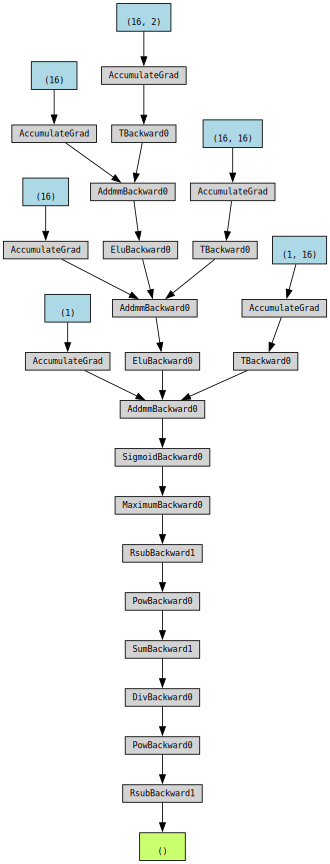

In [11]:
batch = next(iter(test_loader))

var_mapping = {}

kb.partition_data(var_mapping,batch, loaders[0])

kb.rules[0].comp_graph(var_mapping)